In [ ]:
!pip install transformers

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchtext
import json
import random
import os
from scipy import interpolate
import re

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Data

In [ ]:
!unzip wikipedia_data_v3.zip

In [ ]:
def extract_text(folder_name):
  folder_names = os.listdir(folder_name)
  # put all text in a list
  text = []
  for folder in folder_names:
    with open(folder_name + '/' + folder + '/text.json') as file:
      file_content = file.read()
      file_content_str = json.loads(file_content)
      # need to convert the file content to a dict to extract text
      file_content_dict = json.loads(file_content_str)
      text.append(file_content_dict["text"])
  return text

In [ ]:
text = extract_text('wikipedia_data_v3')

In [ ]:
def preprocess_text(text):
  text_prepros = []
  for ex in text:
    new1 = re.sub('\n.+\|thumb.*\n?(.*)?', '', ex)
    new2 = re.sub('\n?(.*)?\|thumb.*\n', '', new1)
    new3 = re.sub('\n.+thumb\|.*\n?(.*)?', '', new2)
    new4 = re.sub('\n?(.*)?thumb\|.*\n', '', new3)
    new5 = re.sub('\n.+\|thumbnail.*\n?(.*)?', '', new4)
    new6 = re.sub('\n?(.*)?\|thumbnail.*\n', '', new5)
    new7 = re.sub('\n.+thumbnail\|.*\n?(.*)?', '', new6)
    new8 = re.sub('\n?(.*)?thumbnail\|.*\n', '', new7)
    new9 = new8.lstrip(' ')
    new10 = new9.lstrip('\n')
    text_prepros.append(new10)
  return text_prepros

In [ ]:
text_clean = preprocess_text(text)

In [ ]:
folder_names = os.listdir("wikipedia_data_v3")
ind = folder_names.index("Agriculture")
text_clean[ind] = text_clean[ind].replace('\nthumb |upright=1.35 |Centres of origin, as numbered by Nikolai Vavilov in the 1930s. Area 3 (gray) is no longer recognised as a centre of origin, and Papua New Guinea (area P, orange) was identified more recently.\n', '')

In [ ]:
text_clean[85]

'Gasketball is an action sports video game for the iPad by Mikengreg, an independent development team of Michael Boxleiter and Greg Wohlwend. Players flick basketballs through 2D physics puzzles into the hoop in single-player, local multiplayer, and asynchronous HORSE-style online multiplayer modes. The game is free-to-play with in-app purchases. Development began in mid 2011 following Mikengreg\'s successful Solipskier. They were able to live from the earnings for Gasketball two year development at their previous salary, which afforded them the stability to try new avenues and reject prototypes, though they worked 100-hour weeks. Towards the end of their development, they ran out of money and lived on the couches of friends. It was released on August 9, 2012, and the game did not reach their desired conversion rate at the time of launch.\n\nThe game received "generally favorable" reviews, according to video game review score aggregator Metacritic. Pocket Gamer gave the game their silv

Text(0.5, 1.0, 'Effect of preprocessing on text length')

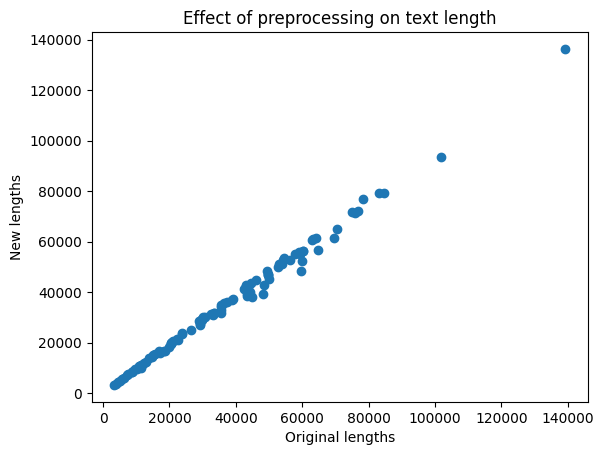

In [ ]:
len_orig = [len(i) for i in text]
len_preproc = [len(i) for i in text_clean]

plt.scatter(len_orig, len_preproc)
plt.xlabel("Original lengths")
plt.ylabel("New lengths")
plt.title("Effect of preprocessing on text length")

### Tokenizers and Models

In [ ]:
tokenizergpt2 = GPT2Tokenizer.from_pretrained("gpt2")
tokenizergpt2.padding_side = "left"
tokenizergpt2.pad_token = tokenizergpt2.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
modelgpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
modelgpt2.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
tokenizergpt2(tokenizergpt2.eos_token)

{'input_ids': [50256], 'attention_mask': [1]}

In [ ]:
tokenizergpt2.eos_token

'<|endoftext|>'

In [ ]:
tokenizergpt2_large = GPT2Tokenizer.from_pretrained("gpt2-xl")
tokenizergpt2_large.padding_side = "left"
tokenizergpt2_large.pad_token = tokenizergpt2_large.eos_token

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

In [ ]:
all_possible_tokens = list(tokenizergpt2_large.get_vocab().keys())
print(all_possible_tokens)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '®', '¯', '°', '±', '²', '³', '´', 'µ', '¶', '·', '¸', '¹', 'º', '»', '¼', '½', '¾', '¿', 'À', 'Á', 'Â', 'Ã', 'Ä', 'Å', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Ë', 'Ì', 'Í', 'Î', 'Ï', 'Ð', 'Ñ', 'Ò', 'Ó', 'Ô', 'Õ', 'Ö', '×', 'Ø', 'Ù', 'Ú', 'Û', 'Ü', 'Ý', 'Þ', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', '÷', 'ø', 'ù', 'ú', 'û', 'ü', 'ý', 'þ', 'ÿ', 'Ā', 'ā', 'Ă', 'ă', 'Ą', 'ą', 'Ć', 'ć', 'Ĉ', 'ĉ', 'Ċ', 'ċ'

In [ ]:
modelgpt2_large = GPT2LMHeadModel.from_pretrained("gpt2-xl")
modelgpt2_large.to(device)

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)

### Functions

In [ ]:
# encode all the text
def encode(text, tokenizer):
  inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=1001)
  #inputs.to(device);
  # remove examples that don't have a 1000 tokens
  long_enough_rows = torch.nonzero(inputs["input_ids"][:, 0] != 50256).squeeze()
  input_ids = inputs["input_ids"][long_enough_rows]
  attention_mask = inputs["attention_mask"][long_enough_rows]
  return input_ids, attention_mask

In [ ]:
def measure_accuracy(input_ids, attention_mask, model, context_lengths, batch_size, file_name, top_x=1):
  # construct contexts and run batch generation
  # key is context length, value is the accuracy (number of correct next token predictions divided by number of examples)
  output_dict = {}
  for c in context_lengths:
    output_dict[c] = 0
    if c >= 100:
      batch_size_to_use=2
    else:
      batch_size_to_use=batch_size
    print(batch_size_to_use)
    for b in range(0, input_ids.size()[0], batch_size_to_use):
      input_ids_curr = input_ids[b:b+batch_size_to_use, 0:c]
      attention_mask_curr = attention_mask[b:b+batch_size_to_use, 0:c]
      correct_tokens = input_ids[b:b+batch_size_to_use, c]

      input_ids_curr = input_ids_curr.to(device);
      attention_mask_curr = attention_mask_curr.to(device);
      correct_tokens = correct_tokens.to(device);
      with torch.inference_mode():
        pred = model.generate(input_ids=input_ids_curr, attention_mask=attention_mask_curr, do_sample=False, max_new_tokens=1, pad_token_id=50256, output_scores=True, return_dict_in_generate=True)
      # get logits and softmax
      probs = torch.softmax(pred.scores[0], dim=-1)
      check_probs_sum_1 = torch.sum(probs, dim=1)
      if torch.all(check_probs_sum_1) == False:
        print("Error: Probabilities don't sum to one")
      # get the top x tokens based on probability
      top_values, top_ind = torch.topk(probs, k=top_x)
      # with torch.inference_mode():
      #   pred = model.generate(input_ids=input_ids_curr, attention_mask=attention_mask_curr, do_sample=False, max_new_tokens=1, pad_token_id=50256)
      # predicted_tokens = pred[:, -1]
      # accuracy = torch.eq(predicted_tokens, correct_tokens).sum().item()
      accuracy = torch.any(top_ind==correct_tokens.view(-1, 1), dim=1).sum().item()
      output_dict[c] += accuracy

    output_dict[c] = output_dict[c]/input_ids.size()[0]

  with open(file_name, "w") as file:
    json.dump(output_dict, file)
  return output_dict

### Data Analysis for GPT-2 x-large

In [ ]:
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2_large)

In [ ]:
input_ids.shape

torch.Size([100, 1001])

In [ ]:
truncated_text = []
for ex in input_ids:
  truncated_text.append(''.join([tokenizergpt2_large.decode(token) for token in ex]))

In [ ]:
all_data = pd.DataFrame({'text': truncated_text})
all_data.to_csv("data_final.csv")

In [ ]:
for t in range(0, len(truncated_text)):
  if "thumb" in truncated_text[t]:
    print(t)

# these articles actually have the word thumb in it or it is part of a word

21
32


In [ ]:
# there is a drop at 600: what are the two tokens?
for ex in input_ids:
  print(tokenizergpt2_large.decode(ex[599]) + tokenizergpt2_large.decode(ex[600]))

 very well
 renamed it
 mm
o lobby
D),
 However,
root juice
, prom
 Eritre
 at which
itors and
, and
choa
UCN
  Episode
. Page
 loves,
 inheritance preceded
 occl
 book in
 through metallic
 this.
 I'll
 Before introducing
 lentils
iter and
ia,
, Beer
: Oxford
 frenzy,
 as selection
 the spinal
 (June
 rights,
able errors
 examples,
 year,
a).
 the University
 thinkers,
 when the
. Curtis
 ever lived
: E
 of Ireland
moved
's first
 efforts of
 that bacterial
-down
 fish in
 1925 Hastings
 of their
 Louise and
 In various
 "no
 there was
 Because 3
 The economy
archari
ign Highway
 the stadium
 the atmosphere
 the mar
 proprietary network
s a
 grant.
 their property
 the idea
 first,
 return David
 made during
 important purposes
 anchorages
, Cr
 Hippob
elom
-8



. Within
1753
 in the
. 
 bond;
 derived from
 March 25
 which is
 be symm
), is
 oases
 cause of
 typically considered
 conflict with
 She therefore
, Ang
 composed of
. Chinese
 the dominance
 section,
a,


In [ ]:
# there is a drop at 600: what are the two tokens?
for ex in input_ids:
  print(tokenizergpt2_large.decode(ex[590]) + tokenizergpt2_large.decode(ex[610]))

 as payment
 only the
  the
 Ten,
es ap
 the problem
 beet components
, such
 had Mer
 City.
ro as
 approach attributed
 into Prize
 the is
E February
 Saudi of
 her pet
 de the
,1
. 21
 whichs
 synthesis extensively
 the."
 1970 designated
ornax
k two
 research particular
 ancient Love
 Progressive.
 bleed but
 over as
 lower spinal
 Mysteries vol
 education global
 The one
's animals
 ( e
 age the
 location

 F.
. England
 thereforeole
, Early
 itag
01 the
ς�
 accounting During
 Bronx University
 wherever by
ish (
 as in
 other a
 objectsysics
 reserve.
 the TNT
 was version
 could enormous
 does of
 ranks.
oyas
 a to
 Fields

energy called

 C
  World
ft their
H000
 both,
 toCommercial
 ofoke
 drown way
 and weak
 habitat chest
 between of
. 
 names second
 Platic
 in deliveries
 affectedamin
 the,
a plant
inations term
 gave genus
 and,
cut words
 blossStaff
 New

 or the
 the Ac
ocks life
 system

 unexpected According
 that the
." the
 attack a
 baseballbat
ini merit
 Thethat
ind

In [ ]:
# there is a peak at 100: what are the two tokens?
for ex in input_ids:
  print(tokenizergpt2_large.decode(ex[99]) + tokenizergpt2_large.decode(ex[100]))

 behind only
 Boston,
 producing districts
 the World
 by a
 Anna is
cht and
,557
ana and
 City borough
 special adaptations

The



 elephants have
 co-
 raw materials
 Jonathan Freeman
a plants
culata
The rock
, and
 "e
 widespread popularity
 which shared
 Plants were
 earnings for
, and
 Wiley 2013
osmith
 Marlin
rytis
 descriptions of
 work,
ised and
 and can
 examples are
The bald
 the moth
 of the
 think tank
 set of
 older specimen
 Dragonflies
, provides
 and the
 for the
 corporate collapses
 eminent scientists
 of the
 are up
 tetrap
 players.
mology is
 located to
 BlackBerry 10
 Diana "
purpose alloc
 and determine
 area of
 blacktip
.

on was
 reduced Plan
 grasses
ysics.
 the North
 and hundreds
 have their
 cryptographic key
water fish
-climate
.

 found in
 Brooklyn Bridge
 operates 6
 is a
ilaterians
 Jet Age
 and buoy
 known forms
 or o
 along with
 Himalaya
, and
like structure
 hubs,
 remot
 Australian C
. In
 that falls
  The
giea
 considered the
 obtainable
 prod

### Experiments

In [ ]:
def plot(output_filename, label_line):
  # plot
  with open(output_filename) as f:
    content = f.read()
  acc = json.loads(content)
  x_1 = list(acc)
  y_1 = np.array(list(acc.values()), dtype='float64')

  plt.figure(figsize=(11, 5))
  plt.plot(x_1, y_1, label=label_line)
  plt.legend()
  plt.xlabel("Context Length")
  plt.ylabel("Average accuracy")
  plt.title("Average Accuracy vs Context Length")
  plt.xticks(rotation = 25)
  plt.show()

In [ ]:
# 100 examples: GPT-2 small, top-1
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2, context_lengths=context_lengths, batch_size=16, file_name = "gpt2small_100ex_p1.json", top_x=1)

In [ ]:
# 100 examples: GPT-2 x-large, top-1
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2_large)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2_large, context_lengths=context_lengths, batch_size=8, file_name = "gpt2large_100ex_p1.json", top_x=1)

In [ ]:
# 50 examples: GPT-2 x-large, top-1
random_50_ex = torch.randperm(input_ids.size(0))[:50]
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2_large)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids[random_50_ex], attention_mask=attention_mask[random_50_ex], model=modelgpt2_large, context_lengths=context_lengths, batch_size=8, file_name = "gpt2large_50ex_p1.json", top_x=1)

In [ ]:
# 75 examples: GPT-2 x-large, top-1
random_75_ex = torch.randperm(input_ids.size(0))[:75]
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2_large)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids[random_75_ex], attention_mask=attention_mask[random_75_ex], model=modelgpt2_large, context_lengths=context_lengths, batch_size=8, file_name = "gpt2large_75ex_p1.json", top_x=1)

In [ ]:
# 100 examples: GPT-2 x-large, top-2
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2_large)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2_large, context_lengths=context_lengths, batch_size=8, file_name = "gpt2large_100ex_p2.json", top_x=2)

In [ ]:
# 100 examples: GPT-2 x-large, top-3
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2_large)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2_large, context_lengths=context_lengths, batch_size=8, file_name = "gpt2large_100ex_p3.json", top_x=3)

In [ ]:
# 100 examples: GPT-2 x-large, top-4
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2_large)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2_large, context_lengths=context_lengths, batch_size=8, file_name = "gpt2large_100ex_p4.json", top_x=4)

In [ ]:
# 100 examples: GPT-2 x-large, top-5
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2_large)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2_large, context_lengths=context_lengths, batch_size=8, file_name = "gpt2large_100ex_p5.json", top_x=5)

### Comparisons

##### GPT-2 small vs x-large - 100 ex (preprocessed)

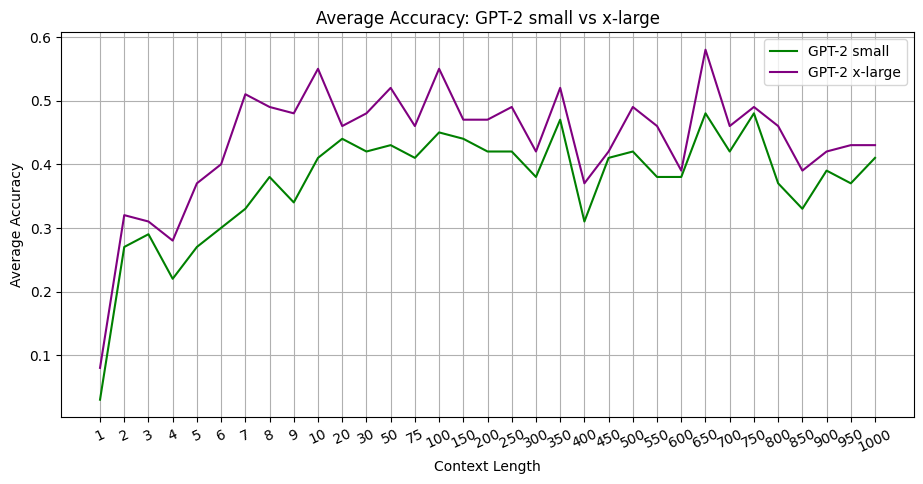

In [ ]:
with open("gpt2small_100ex_p1.json") as f:
  content = f.read()
acc_small = json.loads(content)
with open("gpt2large_100ex_p1.json") as f:
  content = f.read()
acc_large = json.loads(content)
x_1 = list(acc_small)
y_1 = np.array(list(acc_small.values()), dtype='float64')
x_2 = list(acc_large)
y_2 = np.array(list(acc_large.values()), dtype='float64')
plt.figure(figsize=(11, 5))
plt.plot(x_1, y_1, label="GPT-2 small", color='green')
plt.plot(x_2, y_2, label="GPT-2 x-large", color='purple')
plt.xticks(rotation = 25)
plt.legend()
plt.xlabel("Context Length")
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy: GPT-2 small vs x-large")
plt.grid()
plt.show()

##### GPT-2 x-large (50 ex vs 75 ex vs 100 ex)

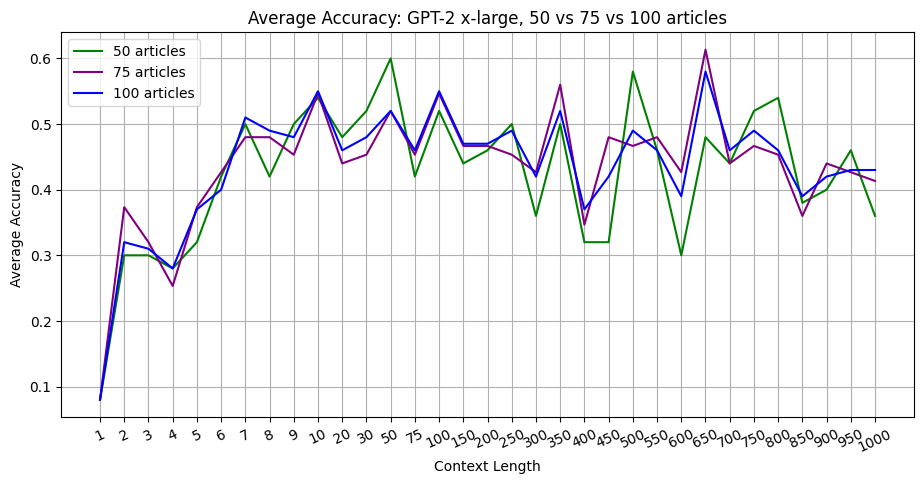

In [ ]:
with open("gpt2large_50ex_p1.json") as f:
  content = f.read()
acc_large = json.loads(content)
with open("gpt2large_75ex_p1.json") as f:
  content = f.read()
acc_large_data2 = json.loads(content)
with open("gpt2large_100ex_p1.json") as f:
  content = f.read()
acc_large_data3 = json.loads(content)
x_1 = list(acc_large)
x_2 = list(acc_large_data2)
x_3 = list(acc_large_data3)
y_1 = np.array(list(acc_large.values()), dtype='float64')
y_2 = np.array(list(acc_large_data2.values()), dtype='float64')
y_3 = np.array(list(acc_large_data3.values()), dtype='float64')
plt.figure(figsize=(11, 5))
plt.plot(x_1, y_1, label="50 articles", color='green')
plt.plot(x_2, y_2, label="75 articles", color='purple')
plt.plot(x_3, y_3, label="100 articles", color='blue')
#plt.xscale('log')
plt.xticks(rotation = 25)
plt.legend()
plt.grid()
plt.xlabel("Context Length")
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy: GPT-2 x-large, 50 vs 75 vs 100 articles")
plt.show()

##### GPT-2 x-large (top 1 vs top 2 vs top top 3 vs top 4 vs top 5)

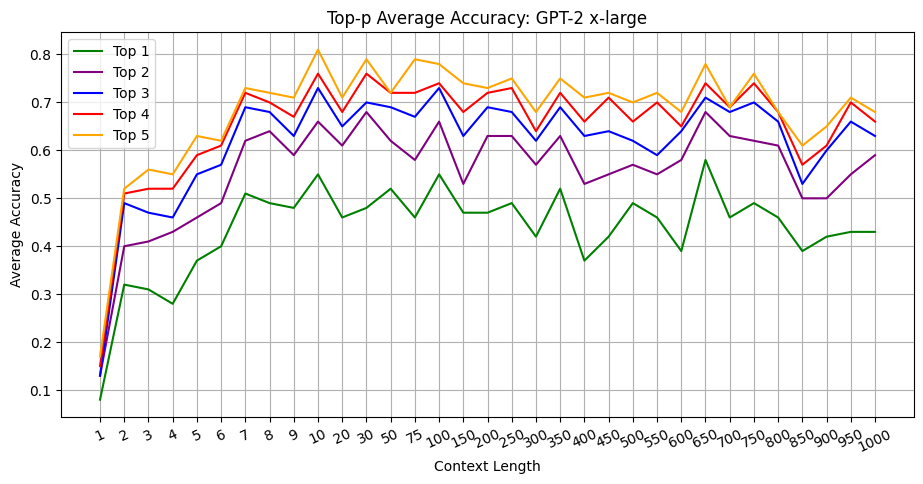

In [ ]:
with open("gpt2large_100ex_p1.json") as f:
  content = f.read()
top1 = json.loads(content)
with open("gpt2large_100ex_p2.json") as f:
  content = f.read()
top2 = json.loads(content)
with open("gpt2large_100ex_p3.json") as f:
  content = f.read()
top3 = json.loads(content)
with open("gpt2large_100ex_p4.json") as f:
  content = f.read()
top4 = json.loads(content)
with open("gpt2large_100ex_p5.json") as f:
  content = f.read()
top5 = json.loads(content)
x_1 = list(top1)
y_1 = np.array(list(top1.values()), dtype='float64')
x_2 = list(top2)
y_2 = np.array(list(top2.values()), dtype='float64')
x_3 = list(top3)
y_3 = np.array(list(top3.values()), dtype='float64')
x_4 = list(top4)
y_4 = np.array(list(top4.values()), dtype='float64')
x_5 = list(top5)
y_5 = np.array(list(top5.values()), dtype='float64')
plt.figure(figsize=(11, 5))
plt.plot(x_1, y_1, label="Top 1", color='green')
plt.plot(x_2, y_2, label="Top 2", color='purple')
plt.plot(x_3, y_3, label="Top 3", color='blue')
plt.plot(x_4, y_4, label="Top 4", color='red')
plt.plot(x_5, y_5, label="Top 5", color='orange')
plt.xticks(rotation = 25)
plt.legend()
plt.xlabel("Context Length")
plt.ylabel("Average Accuracy")
plt.title("Top-p Average Accuracy: GPT-2 x-large")
plt.grid()
plt.show()